In [119]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as ml
from scipy import optimize
%matplotlib inline
ml.rcParams['figure.figsize'] = (8.0, 5.0)
ml.rcParams['text.usetex'] =True
ml.rc('font', family='serif',size=16)

In [120]:
g0 = 3100
g1 = 380
g3 = 290
g4 = 141
g2 = -15
g5 = 50
Dt2 = 0.0#-2.3
Dt3=0.0
Dtp = 10.5

In [121]:
def getBMatrixABCA(kx, ky, Dt, mu, xi):
    v0 = 0.5 * np.sqrt(3) * g0
    v3 = 0.5 * np.sqrt(3) * g3
    v4 = 0.5 * np.sqrt(3) * g4
    kx, ky = np.asarray(kx), np.asarray(ky)
    p = xi * kx + ky * 1j
    pc = xi * kx - ky * 1j
    idt = np.ones(kx.shape, dtype=float)
    Hl = np.array([[(Dt + Dt2 - mu)*idt, v0*pc, -v4*pc, -v3*p, 0*idt, 0.5*g2*idt, 0*idt, 0*idt],
                   [v0*p, (Dt + Dt2 + Dtp - mu)*idt, g1*idt, -v4*pc, 0*idt, 0*idt, 0*idt, 0*idt],
                   [-v4*p, g1*idt, (Dt/3 - Dt3 - Dt2 + Dtp - mu)*idt, v0*pc, -v4*pc, -v3*p, 0*idt, 0.5*g2*idt],
                   [-v3*pc, -v4 * p, v0*p, (Dt/3 - Dt3 - Dt2 + Dtp - mu)*idt, g1*idt, -v4*pc, 0*idt, 0*idt],
                   [0*idt, 0*idt, -v4*p, g1*idt,(-Dt/3 + Dt3 - Dt2 + Dtp - mu)*idt, v0*pc, -v4*pc, -v3*p],
                   [0.5*g2*idt, 0*idt, -v3*pc, -v4*p, v0*p, (-Dt/3 + Dt3 - Dt2 + Dtp - mu)*idt, g1*idt, -v4*pc],
                   [0*idt, 0*idt, 0*idt, 0*idt, -v4*p, g1*idt, (Dt2 - Dt + Dtp - mu)*idt, v0*pc],
                   [0*idt, 0*idt, 0.5*g2*idt, 0*idt, -v3*pc, -v4*p, v0*p, (Dt2 - Dt - mu)*idt]])
    return np.moveaxis(Hl, [0,1], [-2,-1])

In [122]:
def getVMatrix(xi, xy):
    v0 = 0.5 * np.sqrt(3) * g0
    v3 = 0.5 * np.sqrt(3) * g3
    v4 = 0.5 * np.sqrt(3) * g4
    p = xi if xy else 1j
    pc = xi if xy else -1j
    Vl = np.array([[0, v0*pc, -v4*pc, -v3*p, 0, 0, 0, 0],
                   [v0*p, 0, 0, -v4*pc, 0, 0, 0, 0],
                   [-v4*p, 0, 0, v0*pc, -v4*pc, -v3*p, 0, 0],
                   [-v3*pc, -v4 * p, v0*p, 0, 0, -v4*pc, 0, 0],
                   [0, 0, -v4*p, 0, 0, v0*pc, -v4*pc, -v3*p],
                   [0, 0, -v3*pc, -v4*p, v0*p, 0, 0, -v4*pc],
                   [0, 0, 0, 0, -v4*p, 0, 0, v0*pc],
                   [0, 0, 0, 0, -v3*pc, -v4*p, v0*p, 0]])
    return np.moveaxis(Vl, [0,1], [-2,-1])

In [123]:
def xi(kx, ky, en, fdl,kmin):
    if np.abs(kx**2+ky**2)<kmin:
        kx=kmin
        ky=0.0
        ikx = np.where(kx/2-kr<=0)[0][0]
        iky = np.where(ky/2-kr<=0)[0][0]
    else:
        ikx = np.where(kx/2-kr<=0)[0][0]
        iky = np.where(ky/2-kr<=0)[0][0]
        ikx = ikx if np.abs(kx/2-kr[ikx]) < np.abs(kx/2-kr[ikx-1]) or ikx==0 else ikx-1
        iky = iky if np.abs(ky/2-kr[iky]) < np.abs(ky/2-kr[iky-1]) or iky==0 else iky-1
    indsx = Nmax-2*ikx if Nmax-2*ikx>=0 else 2*ikx-Nmax 
    indsy = Nmax-2*iky if Nmax-2*iky>=0 else 2*iky-Nmax
    index = 2*ikx if Nmax-2*ikx>=0 else 2*(Nmax-ikx)
    indey = 2*iky if Nmax-2*iky>=0 else 2*(Nmax-iky)
    return (st**2/(2*np.pi)**2)*np.sum((fdl[indsx:,indsy:]-fdl[0:index,0:indey])/
                   (en[indsx:,indsy:]-en[0:index,0:indey]+1e-12j))

def xiw(kx, ky, en, ev, fdl, kmin):
    if np.abs(kx**2+ky**2)<kmin:
        kx=kmin
        ky=0.0
        ikx = np.where(kx/2-kr<=0)[0][0]
        iky = np.where(ky/2-kr<=0)[0][0]
    else:
        ikx = np.where(kx/2-kr<=0)[0][0]
        iky = np.where(ky/2-kr<=0)[0][0]
        ikx = ikx if np.abs(kx/2-kr[ikx]) < np.abs(kx/2-kr[ikx-1]) or ikx==0 else ikx-1
        iky = iky if np.abs(ky/2-kr[iky]) < np.abs(ky/2-kr[iky-1]) or iky==0 else iky-1
    indsx = Nmax-2*ikx if Nmax-2*ikx>=0 else 2*ikx-Nmax 
    indsy = Nmax-2*iky if Nmax-2*iky>=0 else 2*iky-Nmax
    index = 2*ikx if Nmax-2*ikx>=0 else 2*(Nmax-ikx)
    indey = 2*iky if Nmax-2*iky>=0 else 2*(Nmax-iky)
    wv = np.abs(np.einsum('ijk, ijk->ij', np.conj(ev[indsx:,indsy:]), ev[0:index,0:indey]))**2
    return (st**2/(2*np.pi)**2)*np.sum(wv*(fdl[indsx:,indsy:]-fdl[0:index,0:indey])/
                   (en[indsx:,indsy:]-en[0:index,0:indey]+1e-12j))

def xig(kx, ky, enb, env, fdl, kmin):
    if WaveFunc:
        return xiw(kx, ky, enb, env, fdl, kmin)
    else :
        return xi(kx, ky, enb, fdl,kmin)

def FD(en, mu, T):
    return 0.5*(1-np.tanh((en-mu)/(2*T)))

def DOS(en, mu, T):
    dmu = 0.001
    return (st**2/(2*np.pi)**2)*np.sum((FD(en,mu+dmu,T)-FD(en,mu-dmu,T))/(2*dmu))

In [124]:
Dl=60
Nmax=800
kmax=0.20
Tc = 0.015
WaveFunc = False

In [125]:
kr, st = np.linspace(-kmax,kmax, Nmax, retstep=True, endpoint=False)
KY, KX = np.meshgrid(kr, kr)
w, v = np.linalg.eigh(getBMatrixABCA(KX, KY, Dl, 0.0, 1))

In [66]:
muc=56.85
fdl = FD(w[:,:,4],muc,Tc)
dsl = DOS(w[:,:,4],muc,Tc)
enb = w[:,:,4]
env = v[:,:,:,4]

(-0.15, 0.15)

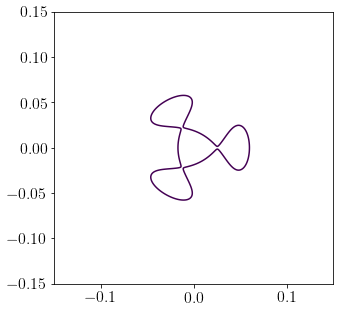

In [131]:
ml.rcParams['figure.figsize'] = (5.0, 5.0)
plt.contour(KX,KY,w[:,:,4], [60.06])
67.45
#ko=k00
#plt.scatter(ko[:,1].astype(float)*np.cos(ko[:,0].astype(float)), ko[:,1].astype(float)*np.sin(ko[:,0].astype(float)))
#plt.scatter(k00[NFS//2,1],0)
#plt.scatter(kxlr[1,1]*np.cos(kxlr[1,0]),0)
plt.xlim([-0.15,0.15])
plt.ylim([-0.15,0.15])

In [13]:
kmin=4e-8
kx=np.linspace(0.0,0.2,500)
WaveFunc = False
xilx=np.array([-np.real(xig(kxl,0,enb,env,fdl,kmin)) for kxl in kx])
xily=np.array([-np.real(xig(0,kxl,enb,env,fdl,kmin)) for kxl in kx])

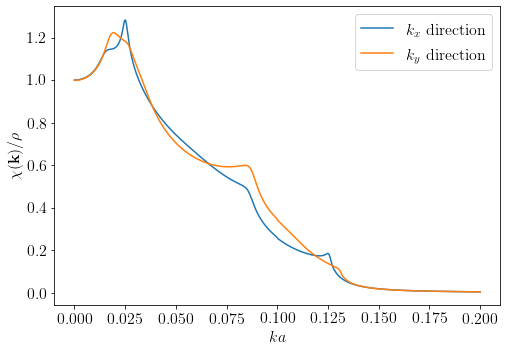

In [14]:
ml.rcParams['figure.figsize'] = (8.0, 5.5)
plt.plot(kx,xilx/dsl, label=r'$k_x$ direction')
plt.plot(kx,xily/dsl, label=r'$k_y$ direction')
plt.xlabel(r'$ka$')
plt.ylabel(r'$\chi(\mathbf{k})/\rho$')
plt.legend()
plt.show()

In [34]:
a=2.46

def Veff(kx,ky, eps, d):
    kx, ky = np.asarray(kx), np.asarray(ky)
    Vamp = 4.8**2*10**3/(1.6*eps*a)
    kabs = np.sqrt(kx**2+ky**2)
    ind = np.where(kabs<1e-6)
    kabs[ind[0], ind[1]]=1e-6
    return 2*np.pi*Vamp*np.tanh(kabs*d)/(kabs)

In [35]:
def func(k,th, Dt1, mu):
    w =np.linalg.eigvalsh(getBMatrixABCA(k*np.cos(th), k*np.sin(th), Dt1, mu, 1))
    return w[4]

def func1(k0x, k0y, k, th, Dt1, mu):
    w =np.linalg.eigvalsh(getBMatrixABCA(k0x+k*np.cos(th), k0y+k*np.sin(th), Dt1, mu, 1))
    return w[4]

def catch(func, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except RuntimeError:
        return None
    except ValueError:
        return None

In [36]:
def findNext(ind, kxl, kyl, dkm):
    kx = kxl[ind]
    ky = kyl[ind]
    inds=np.where(np.sqrt((kx-kxl)**2+(ky-kyl)**2)>dkm)[0]
    indl=np.where(inds-ind>0)[0]
    if len(indl)>0:
        return inds[indl[0]]
    else:
        return None
    
def findAll(kxl, kyl, dkm):
    indl=[0]
    indi=findNext(indl[-1], kxl, kyl, dkm)
    while indi!=None:
        indl.append(indi)
        indi=findNext(indl[-1], kxl, kyl, dkm)
    if np.sqrt((kxl[indl[-1]]-kxl[indl[0]])**2 + (kyl[indl[-1]]-kyl[indl[0]])**2)<dkm/2:
        indl.pop()
    return kxl[indl], kyl[indl],indl

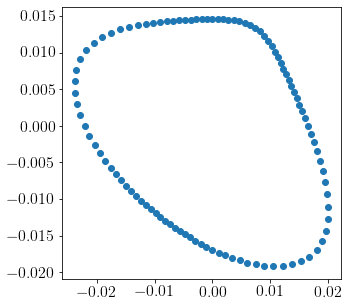

In [191]:
ml.rcParams['figure.figsize'] = (5.0, 5.0)
ko=k21
plt.scatter(ko[:,1].astype(float)*np.cos(ko[:,0].astype(float)), ko[:,1].astype(float)*np.sin(ko[:,0].astype(float)))

In [167]:
 optimize.brentq(lambda k:func1(kc,0,k,np.pi/2, Dl, muc), 0.0,0.1)

ValueError: f(a) and f(b) must have different signs

In [54]:
th

NameError: name 'th' is not defined

In [101]:
NFS = 100
Dl=69
muc=68.69
mlt=0.05
cutoff=5*st

In [102]:
thr = np.linspace(-np.pi,np.pi,NFS,endpoint=False)
thl=np.array([0,np.pi])
kxlr = np.array([[th, catch(optimize.newton, lambda k:func(k,th, Dl, muc), 1.2*kmax)] for th in thl])
ko = np.array([[th, catch(optimize.brentq, lambda k:func(k,th, Dl, muc), 0.01, 1.3*kmax)] for th in thr])
innerpocket=1
if kxlr[1,1]==None or kxlr[0,1]==None or kxlr[0,1]<0 or kxlr[1,1]<0:
    innerpocket=0
elif kxlr[1,1] < 0.28*kxlr[0,1]:
    innerpocket=2
else:
    try:
        optimize.brentq(lambda k:func(k,thr[0], Dl, muc), 0.002, ko[0,1]-0.0001)
    except ValueError:
        innerpocket=4
pref=5
prefm=1.8
if innerpocket==0:
    k1 = catch(optimize.newton,lambda k:func(k,0, Dl, muc), kmax+0.4)
    k1m = catch(optimize.newton,lambda k:func(k,0, Dl, muc), -kmax)
    if k1!=None and k1>0 and k1m!=None and k1m<0:
        innerpocket=3
        thr = np.linspace(-np.pi,np.pi,NFS,endpoint=False)
        k0 = optimize.brentq(lambda k:func(k,0, Dl, muc), 0.0, k1-0.00001)
        kc = 0.5*(k0+k1)
        kt = optimize.newton(lambda k:func1(kc,0,k,np.pi/2, Dl, muc), 0.0001)
        k0m = optimize.brentq(lambda k:func(k,0, Dl, muc), 0.0, k1m+0.0001)
        kcm = 0.5*(k0m+k1m)
        ktm = optimize.newton(lambda k:func1(kcm,0,k,np.pi/2, Dl, muc), 0.0001)
        k01 = np.array([[th, catch(optimize.brentq,lambda k:func1(kc, 0,k,th, Dl, muc), 0, pref*kt)] for th in thr])
        k11 = np.array([[th, catch(optimize.brentq,lambda k:func1(kc*np.cos(2*np.pi/3), kc*np.sin(2*np.pi/3),k,th,Dl,muc), 0, pref*kt)] for th in thr])
        k21 = np.array([[th, catch(optimize.brentq,lambda k:func1(kc*np.cos(2*np.pi/3), kc*np.sin(-2*np.pi/3),k,th,Dl,muc), 0, pref*kt)] for th in thr])
        k01m = np.array([[th, catch(optimize.brentq,lambda k:func1(kcm, 0,k,th, Dl, muc), 0, prefm*ktm)] for th in thr])
        k11m = np.array([[th, catch(optimize.brentq,lambda k:func1(kcm*np.cos(2*np.pi/3), kcm*np.sin(2*np.pi/3),k,th,Dl,muc), 0, prefm*ktm)] for th in thr])
        k21m = np.array([[th, catch(optimize.brentq,lambda k:func1(kcm*np.cos(2*np.pi/3), kcm*np.sin(-2*np.pi/3),k,th,Dl,muc), 0, prefm*ktm)] for th in thr])
        

        k01 = findAll(kc+k01[:,1]*np.cos(k01[:,0]), k01[:,1]*np.sin(k01[:,0]), mlt*np.mean(k01[:,1]) if mlt*np.mean(k01[:,1])>cutoff else cutoff)
        k11 = findAll(kc*np.cos(2*np.pi/3)+k11[:,1]*np.cos(k11[:,0]), kc*np.sin(2*np.pi/3)+k11[:,1]*np.sin(k11[:,0]), mlt*np.mean(k11[:,1]) if mlt*np.mean(k11[:,1])>cutoff else cutoff)
        k21 = findAll(kc*np.cos(2*np.pi/3)+k21[:,1]*np.cos(k21[:,0]), kc*np.sin(-2*np.pi/3)+k21[:,1]*np.sin(k21[:,0]), mlt*np.mean(k21[:,1]) if mlt*np.mean(k21[:,1])>cutoff else cutoff)
        k01m = findAll(kcm+k01m[:,1]*np.cos(k01m[:,0]), k01m[:,1]*np.sin(k01m[:,0]), mlt*np.mean(k01m[:,1]) if mlt*np.mean(k01m[:,1])>cutoff else cutoff)
        k11m = findAll(kcm*np.cos(2*np.pi/3)+k11m[:,1]*np.cos(k11m[:,0]), kcm*np.sin(2*np.pi/3)+k11m[:,1]*np.sin(k11m[:,0]), mlt*np.mean(k11m[:,1]) if mlt*np.mean(k11m[:,1])>cutoff else cutoff)
        k21m = findAll(kcm*np.cos(2*np.pi/3)+k21m[:,1]*np.cos(k21m[:,0]), kcm*np.sin(-2*np.pi/3)+k21m[:,1]*np.sin(k21m[:,0]), mlt*np.mean(k21m[:,1]) if mlt*np.mean(k21m[:,1])>cutoff else cutoff)
        sizes=np.array([len(k01[0]),len(k01[0])+len(k11[0]), len(k01[0])+len(k11[0])+len(k21[0]),
                        len(k01[0])+len(k11[0])+len(k21[0])+len(k01m[0]),
                        len(k01[0])+len(k11[0])+len(k21[0])+len(k01m[0])+len(k11m[0]), 
                        len(k01[0])+len(k11[0])+len(k21[0])+len(k01m[0])+len(k11m[0])+len(k21m[0])])

        krx = np.concatenate((k01[0], k11[0], k21[0], k01m[0], k11m[0], k21m[0]))
        kry = np.concatenate((k01[1], k11[1], k21[1], k01m[1], k11m[1], k21m[1]))
        indsc=np.concatenate((k01[2], k11[2], k21[2], k01m[2], k11m[2], k21m[2]))

    else:
        if k1!=None and k1>0:
            kb=k1-0.001
            kl = k1
        else:
            kb=k1m+0.001
            kl=k1m
        k0 = optimize.brentq(lambda k:func(k,0, Dl, muc), 0.0, kb)
        kc = 0.5*(k0+kl)
        kt = optimize.newton(lambda k:func1(kc,0,k,np.pi/2, Dl, muc), 0.03)
        k01 = np.array([[th, catch(optimize.brentq,lambda k:func1(kc, 0,k,th, Dl, muc), 0, pref*kt)] for th in thr])
        k11 = np.array([[th, catch(optimize.brentq,lambda k:func1(kc*np.cos(2*np.pi/3), kc*np.sin(2*np.pi/3),k,th,Dl,muc), 0, pref*kt)] for th in thr])
        k21 = np.array([[th, catch(optimize.brentq,lambda k:func1(kc*np.cos(2*np.pi/3), kc*np.sin(-2*np.pi/3),k,th,Dl,muc), 0, pref*kt)] for th in thr])
        k01 = findAll(kc+k01[:,1]*np.cos(k01[:,0]), k01[:,1]*np.sin(k01[:,0]), mlt*np.mean(k01[:,1]) if mlt*np.mean(k01[:,1])>cutoff else cutoff)
        k11 = findAll(kc*np.cos(2*np.pi/3)+k11[:,1]*np.cos(k11[:,0]), kc*np.sin(2*np.pi/3)+k11[:,1]*np.sin(k11[:,0]), mlt*np.mean(k11[:,1]) if mlt*np.mean(k11[:,1])>cutoff else cutoff)
        k21 = findAll(kc*np.cos(2*np.pi/3)+k21[:,1]*np.cos(k21[:,0]), kc*np.sin(-2*np.pi/3)+k21[:,1]*np.sin(k21[:,0]), mlt*np.mean(k21[:,1]) if mlt*np.mean(k21[:,1])>cutoff else cutoff)

        sizes=np.array([len(k01[0]), len(k01[0])+len(k11[0]), len(k01[0])+len(k11[0])+len(k21[0])])
        krx = np.concatenate((k01[0], k11[0], k21[0]))
        kry = np.concatenate((k01[1], k11[1], k21[1]))
        indsc=np.concatenate((k01[2], k11[2], k21[2]))
            
elif innerpocket==1:
    ki = np.array([[th[0],optimize.brentq(lambda k:func(k,th[0], Dl, muc), 0.00002, th[1]-0.00001)] for th in zip(thr, ko[:,1])])
    ki = findAll(ki[:,1]*np.cos(ki[:,0]), ki[:,1]*np.sin(ki[:,0]), mlt*np.mean(ki[:,1]) if mlt*np.mean(ki[:,1])>cutoff else cutoff)
    ko = findAll(ko[:,1]*np.cos(ko[:,0]), ko[:,1]*np.sin(ko[:,0]), mlt*np.mean(ko[:,1]) if mlt*np.mean(ko[:,1])>cutoff else cutoff)
    sizes=np.array([len(ki[0]), len(ki[0])+len(ko[0])])

    krx = np.concatenate((ki[0], ko[0]))
    kry = np.concatenate((ki[1], ko[1]))
    indsc = np.concatenate((ki[2], ko[2]))
elif innerpocket==2:
    k00 = np.array([[th, catch(optimize.brentq,lambda k:func(k,th, Dl, muc), 0, kxlr[1,1]+0.01)] for th in thr])
    k0 = optimize.brentq(lambda k:func(k,0, Dl, muc), k00[NFS//2,1]+0.0001, kxlr[0,1]-0.001)
    kc = 0.5*(k0+kxlr[0,1])
    kt = optimize.newton(lambda k:func1(kc,0,k,np.pi/2, Dl, muc), 0.001)
    k01 = np.array([[th, catch(optimize.brentq,lambda k:func1(kc, 0,k,th, Dl, muc), 0, pref*kt)] for th in thr])
    k11 = np.array([[th, catch(optimize.brentq,lambda k:func1(kc*np.cos(2*np.pi/3), kc*np.sin(2*np.pi/3),k,th,Dl,muc), 0, pref*kt)] for th in thr])
    k21 = np.array([[th, catch(optimize.brentq,lambda k:func1(kc*np.cos(2*np.pi/3), kc*np.sin(-2*np.pi/3),k,th,Dl,muc), 0, pref*kt)] for th in thr])
    k00 = findAll(k00[:,1]*np.cos(k00[:,0]), k00[:,1]*np.sin(k00[:,0]), mlt*np.mean(k00[:,1]) if mlt*np.mean(k00[:,1])>cutoff else cutoff)
    k01 = findAll(kc+k01[:,1]*np.cos(k01[:,0]), k01[:,1]*np.sin(k01[:,0]), mlt*np.mean(k01[:,1]) if mlt*np.mean(k01[:,1])>cutoff else cutoff)
    k11 = findAll(kc*np.cos(2*np.pi/3)+k11[:,1]*np.cos(k11[:,0]), kc*np.sin(2*np.pi/3)+k11[:,1]*np.sin(k11[:,0]), mlt*np.mean(k11[:,1]) if mlt*np.mean(k11[:,1])>cutoff else cutoff)
    k21 = findAll(kc*np.cos(2*np.pi/3)+k21[:,1]*np.cos(k21[:,0]), kc*np.sin(-2*np.pi/3)+k21[:,1]*np.sin(k21[:,0]), mlt*np.mean(k21[:,1]) if mlt*np.mean(k21[:,1])>cutoff else cutoff)
    sizes=np.array([len(k00[0]),len(k00[0])+len(k01[0]), len(k00[0])+len(k01[0])+len(k11[0]),
                        len(k00[0])+len(k01[0])+len(k11[0])+len(k21[0])])
    krx = np.concatenate((k00[0], k01[0], k11[0], k21[0]))
    kry = np.concatenate((k00[1], k01[1], k11[1], k21[1]))
    indsc=np.concatenate((k00[2], k01[2], k11[2], k21[2]))
else:    
    ko = findAll(ko[:,1]*np.cos(ko[:,0]), ko[:,1]*np.sin(ko[:,0]), mlt*np.mean(ko[:,1]) if mlt*np.mean(ko[:,1])>cutoff else cutoff)
    sizes=np.array([len(ko[0])])
    krx = ko[0]
    kry = ko[1]
    indsc = ko[2]

print(krx.shape)
vx = getVMatrix(1,True)
vy = getVMatrix(1,False)
wi,vi = np.linalg.eigh(getBMatrixABCA(krx, kry, Dl, 0.0, 1))
vxli = np.real(np.einsum('ik, kl, il->i', np.conj(vi[:,:,4]), vx, vi[:,:,4]))
vyli = np.real(np.einsum('ik, kl, il->i', np.conj(vi[:,:,4]), vy, vi[:,:,4]))
va=np.sqrt(vxli**2+vyli**2)
vm = np.sqrt(1/va)
vm = vm[:,np.newaxis]*vm

if innerpocket==0:
    dk=np.concatenate((np.sqrt((krx[:sizes[0]]-np.concatenate((krx[1:sizes[0]],[krx[0]])))**2+(kry[:sizes[0]]-np.concatenate((kry[1:sizes[0]],[kry[0]])))**2),
                       np.sqrt((krx[sizes[0]:sizes[1]]-np.concatenate((krx[sizes[0]+1:sizes[1]],[krx[sizes[0]]])))**2+(kry[sizes[0]:sizes[1]]-np.concatenate((kry[sizes[0]+1:sizes[1]],[kry[sizes[0]]])))**2),
                       np.sqrt((krx[sizes[1]:]-np.concatenate((krx[sizes[1]+1:],[krx[sizes[1]]])))**2+(kry[sizes[1]:]-np.concatenate((kry[sizes[1]+1:],[kry[sizes[1]]])))**2)))
elif innerpocket==3:
    dk=np.concatenate((np.sqrt((krx[:sizes[0]]-np.concatenate((krx[1:sizes[0]],[krx[0]])))**2+(kry[:sizes[0]]-np.concatenate((kry[1:sizes[0]],[kry[0]])))**2),
                       np.sqrt((krx[sizes[0]:sizes[1]]-np.concatenate((krx[sizes[0]+1:sizes[1]],[krx[sizes[0]]])))**2+(kry[sizes[0]:sizes[1]]-np.concatenate((kry[sizes[0]+1:sizes[1]],[kry[sizes[0]]])))**2),
                       np.sqrt((krx[sizes[1]:sizes[2]]-np.concatenate((krx[sizes[1]+1:sizes[2]],[krx[sizes[1]]])))**2+(kry[sizes[1]:sizes[2]]-np.concatenate((kry[sizes[1]+1:sizes[2]],[kry[sizes[1]]])))**2),
                       np.sqrt((krx[sizes[2]:sizes[3]]-np.concatenate((krx[sizes[2]+1:sizes[3]],[krx[sizes[2]]])))**2+(kry[sizes[2]:sizes[3]]-np.concatenate((kry[sizes[2]+1:sizes[3]],[kry[sizes[2]]])))**2),
                       np.sqrt((krx[sizes[3]:sizes[4]]-np.concatenate((krx[sizes[3]+1:sizes[4]],[krx[sizes[3]]])))**2+(kry[sizes[3]:sizes[4]]-np.concatenate((kry[sizes[3]+1:sizes[4]],[kry[sizes[3]]])))**2),
                       np.sqrt((krx[sizes[4]:sizes[5]]-np.concatenate((krx[sizes[4]+1:sizes[5]],[krx[sizes[4]]])))**2+(kry[sizes[4]:sizes[5]]-np.concatenate((kry[sizes[4]+1:sizes[5]],[kry[sizes[4]]])))**2)))
elif innerpocket==1:
    dk=np.concatenate((np.sqrt((krx[:sizes[0]]-np.concatenate((krx[1:sizes[0]],[krx[0]])))**2+(kry[:sizes[0]]-np.concatenate((kry[1:sizes[0]],[kry[0]])))**2), 
                       np.sqrt((krx[sizes[0]:]-np.concatenate((krx[sizes[0]+1:],[krx[sizes[0]]])))**2+(kry[sizes[0]:]-np.concatenate((kry[sizes[0]+1:],[kry[sizes[0]]])))**2)))
elif innerpocket==2:
    dk=np.concatenate((np.sqrt((krx[:sizes[0]]-np.concatenate((krx[1:sizes[0]],[krx[0]])))**2+(kry[:sizes[0]]-np.concatenate((kry[1:sizes[0]],[kry[0]])))**2),
                       np.sqrt((krx[sizes[0]:sizes[1]]-np.concatenate((krx[sizes[0]+1:sizes[1]],[krx[sizes[0]]])))**2+(kry[sizes[0]:sizes[1]]-np.concatenate((kry[sizes[0]+1:sizes[1]],[kry[sizes[0]]])))**2),
                       np.sqrt((krx[sizes[1]:sizes[2]]-np.concatenate((krx[sizes[1]+1:sizes[2]],[krx[sizes[1]]])))**2+(kry[sizes[1]:sizes[2]]-np.concatenate((kry[sizes[1]+1:sizes[2]],[kry[sizes[1]]])))**2),
                       np.sqrt((krx[sizes[2]:]-np.concatenate((krx[sizes[2]+1:],[krx[sizes[2]]])))**2+(kry[sizes[2]:]-np.concatenate((kry[sizes[2]+1:],[kry[sizes[2]]])))**2)))
else:
    dk=np.sqrt((krx-np.concatenate((krx[1:],[krx[0]])))**2+(kry[:]-np.concatenate((kry[1:],[kry[0]])))**2)     

vll=-(vxli*krx+vyli*kry)/np.sqrt(krx**2+kry**2)    
ml.rcParams['figure.figsize'] = (16.0, 5.5)
fig, (ax1, ax2)= plt.subplots(1,2)
sc=ax1.scatter(krx, kry, c=vll,s=3.8)
plt.colorbar(sc, ax=ax1)
ax1.set_xlabel(r'$k_xa$')
ax1.set_ylabel(r'$k_ya$')

if innerpocket==3:
    ax2.plot(thr[indsc[:sizes[0]]], vll[:sizes[0]])
    ax2.plot(thr[indsc[sizes[0]:sizes[1]]], vll[sizes[0]:sizes[1]])
    ax2.plot(thr[indsc[sizes[1]:sizes[2]]], vll[sizes[1]:sizes[2]])
    ax2.plot(thr[indsc[sizes[2]:sizes[3]]], vll[sizes[2]:sizes[3]])
    ax2.plot(thr[indsc[sizes[3]:sizes[4]]], vll[sizes[3]:sizes[4]])
    ax2.plot(thr[indsc[sizes[4]:sizes[5]]], vll[sizes[4]:sizes[5]])
elif innerpocket==2:
    ax2.plot(thr[indsc[:sizes[0]]], vll[:sizes[0]])
    ax2.plot(thr[indsc[sizes[0]:sizes[1]]], vll[sizes[0]:sizes[1]])
    ax2.plot(thr[indsc[sizes[1]:sizes[2]]], vll[sizes[1]:sizes[2]])
    ax2.plot(thr[indsc[sizes[2]:sizes[3]]], vll[sizes[2]:sizes[3]])
else:
    ax2.plot(thr[indsc[:sizes[0]]], vll[:sizes[0]])
    if innerpocket<2:
        ax2.plot(thr[indsc[sizes[0]:sizes[1]]], vll[sizes[0]:sizes[1]])
    if innerpocket<1:
        ax2.plot(thr[indsc[sizes[1]:sizes[2]]], vll[sizes[1]:sizes[2]])
ax2.set_xlabel(r'$\theta$ around FS')
ax2.set_ylabel(r'$v_\parallel(\mathbf{k})$')

plt.tight_layout()

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [272]:
kxlr

array([[0.        , 0.05932898],
       [3.14159265, 0.01332318]])

In [20]:
kmin=4e-8
qdifx=krx-krx[:,np.newaxis]
qdify=kry-kry[:,np.newaxis]
WaveFunc = True

def retxi(ir, ic):
    return np.real(xig(qdifx[ir,ic],qdify[ir,ic],enb,env,fdl,kmin))

In [21]:
from itertools import starmap
from multiprocessing import Pool
pool = Pool(processes=4)

li=np.array(list(zip(*np.triu_indices(len(qdifx)))))
xiMatt = list(pool.starmap(retxi, li))
xiMat = np.zeros(qdifx.shape)
xiMat[li[:,0],li[:,1]]=xiMatt

In [22]:
eps=4
d=150

def Lamd(epsl=eps, dl=d, TwoPhase=False):
    mult = 2 if TwoPhase else 4
    Mat = (1/(2*np.pi)**2)*np.sqrt(dk[:,np.newaxis]*dk)*(Veff(qdifx,qdify,epsl,dl)/(1-mult*Veff(qdifx,qdify,epsl,dl)*xiMat))*vm
    if WaveFunc:
        w0, v0 = np.linalg.eigh(getBMatrixABCA(krx, kry, Dl, 0.0, 1))
        print(v0.shape)
        Mat = Mat*np.abs(np.dot(np.conj(v0[:,:,4]),v0[:,:,4].T))**2
    lam, psi = np.linalg.eigh(Mat, UPLO='U')
    return lam[:4], psi[:,:4]

In [23]:
WaveFunc = False
lmb=Lamd(TwoPhase=False)

In [24]:
lmb[0]

array([-0.42797159, -0.42585294, -0.04205367, -0.03776038])

In [82]:
dk

array([0.01440281, 0.01426131, 0.01393576, 0.01349686, 0.01311716,
       0.01295811, 0.01308637, 0.01344828, 0.01388994, 0.01423423,
       0.01439516, 0.01440878, 0.01428597, 0.01398006, 0.01354619,
       0.01315078, 0.01296178, 0.01305858, 0.01340072, 0.01384282,
       0.01420472, 0.01438574, 0.01441318, 0.01430822, 0.01402266,
       0.01359599, 0.01318704, 0.01296911, 0.01303393, 0.01335444,
       0.01379462, 0.01417282, 0.01913183])

In [342]:
dpath = "/home/aghazary/Documents/MyWorks/BilayerGraphene/PythonCode/SuperABCA/"
with open(dpath+'EnergyDifWN.npy', 'rb') as f:
    dat = np.load(f,allow_pickle=True)

In [343]:
Dtl=np.arange(1,18.01,1)
datn=[dat[np.where(np.abs(Dtll-dat[:,0])<1e-6)[0]] for Dtll in Dtl]

In [344]:
minp0=np.array([datn[i][5+np.argmin(datn[i][5:,2])] for i in range(len(datn))])

In [308]:
Nmax=400
kr, st = np.linspace(-kmax,kmax, Nmax, retstep=True, endpoint=False)
KY, KX = np.meshgrid(kr, kr)

(-0.08, 0.08)

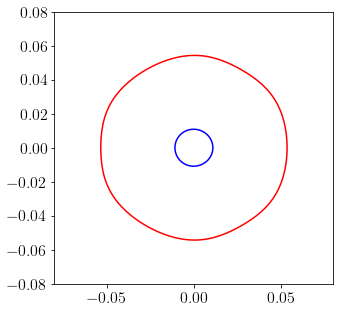

In [355]:
Dl=7
ind=np.where(np.abs(Dl-Dtl)<1e-6)[0]
ml.rcParams['figure.figsize'] = (5.0, 5.0)
w, v = np.linalg.eigh(getBMatrixABCA(KX, KY, minp0[ind,0], 0.0, 1))
plt.contour(KX,KY,w[:,:,4], [minp0[ind,1][0]],colors='b')
plt.contour(KX,KY,w[:,:,4], [minp[ind,1][0]],colors='r')
plt.xlim([-0.08,0.08])
plt.ylim([-0.08,0.08])

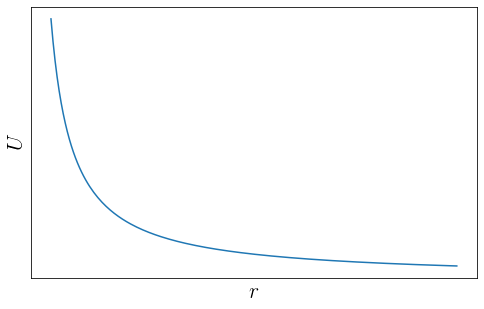

In [363]:
ml.rcParams['figure.figsize'] = (8.0, 5.0)
rl=np.linspace(0.1,2,200)
plt.plot(rl,1/rl)
plt.xlabel(r'$r$',fontsize=22)
plt.ylabel(r'$U$',fontsize=22)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.savefig('Colomb.png',dpi=200)